# Imports + pipeline call

In [5]:
import matplotlib.pyplot as plt

from constants.taxi_c import GeoBounds as gb
from pipelines.taxi_pipeline import build_taxi_dataset

In [6]:
taxi_df = build_taxi_dataset(save_csv=True)

100%|██████████| 50000/50000 [00:00<00:00, 72915.43it/s]
/Users/nnord/uni/projects/taxi_trip/src/features/taxi.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub["route_distance_km"] = sub.progress_apply(
/Users/nnord/uni/projects/taxi_trip/src/features/taxi.py:163: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  done = pd.concat([done, sub], axis=0)
100%|██████████| 50000/50000 [00:00<00:00, 71573.35it/s]
/Users/nnord/uni/projects/taxi_trip/src/features/taxi.py:156: SettingWithCopyWarning: 
A va

# EDA Hist / describe

- 1458644 rows
- 11 columns
- object: id, pickup_datetime, dropoff_datetime, store_and_fwd_flag
- int64: vendor_id, passenger_count, trip_duration
- float64: pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude
- no missing values/categories
- no NaNs
- id can be used for unique ID
- two unique vendors seems to be all right
- ten unique passengers
- two unique store_and_fwd_flag matches with description
- no duplicated rows

In [7]:
taxi_df.describe(include='object')

,id,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,is_group_trip,passenger_count_invalid,pickup_longitude_invalid,pickup_latitude_invalid,dropoff_longitude_invalid,dropoff_latitude_invalid,trip_duration_outlier,is_holiday
count,1458644,1458644,1458644,1458644,1458644,1458644,1458644,1458644,1458644,1458644,1458644,1458644,1458644
unique,1458644,2,6,2,5996,2,2,2,2,2,2,2,2
top,id2875421,2,1,N,60,0,0,0,0,0,0,0,0
freq,1,780302,1033600,1450599,8777,1033600,1458579,1458008,1458372,1453733,1456890,1447937,1431393


## vendor_id

In [8]:
taxi_df['vendor_id'].value_counts()

vendor_id
2    780302
1    678342
Name: count, dtype: int64

In [9]:
taxi_df['vendor_id'].isna().sum()

np.int64(0)

- Only two unique values: 1 and 2.
- Frequencies are relatively balanced.
- No missing values or anomalies detected.

##  pickup_datetime & dropoff_datetime

In [10]:
# Number of missing values
print("Missing pickup_datetime:", taxi_df['pickup_datetime'].isna().sum())
print("Missing dropoff_datetime:", taxi_df['dropoff_datetime'].isna().sum())

Missing pickup_datetime: 0
Missing dropoff_datetime: 0


In [11]:
# Negative or unrealistic trip durations
invalid_times = (taxi_df['dropoff_datetime'] < taxi_df['pickup_datetime'])
print("Trips with negative duration:", invalid_times.sum())

Trips with negative duration: 0


- no negative durations

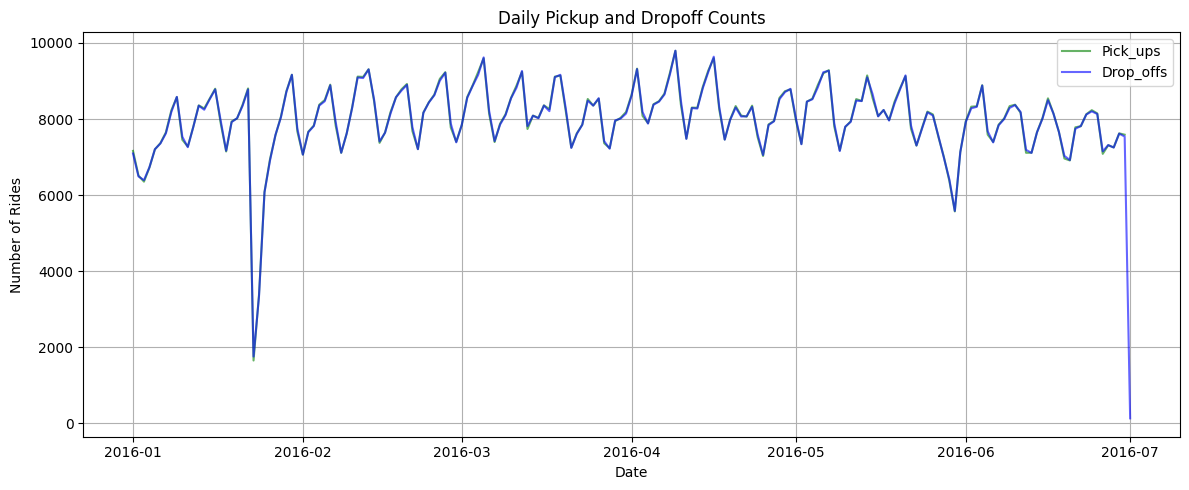

In [12]:
pickup_counts = taxi_df['pickup_datetime'].dt.date.value_counts().sort_index()
dropoff_counts = taxi_df['dropoff_datetime'].dt.date.value_counts().sort_index()

# Plot
fig, ax = plt.subplots(figsize=(12, 5))
pickup_counts.plot(ax=ax, label="Pick_ups", color='green', alpha=0.6)
dropoff_counts.plot(ax=ax, label="Drop_offs", color='blue', alpha=0.6)

ax.set_title("Daily Pickup and Dropoff Counts")
ax.set_xlabel("Date")
ax.set_ylabel("Number of Rides")
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- aligns with expected rush hour effects

##  passenger_count

In [13]:
print(taxi_df['passenger_count'].value_counts().sort_index())

passenger_count
1    1033600
2     210318
3      59896
4      28404
5      78088
6      48338
Name: count, dtype: int64


- 60 with passenger count 0
- 5 with passenger count > 6

<Axes: xlabel='passenger_count'>

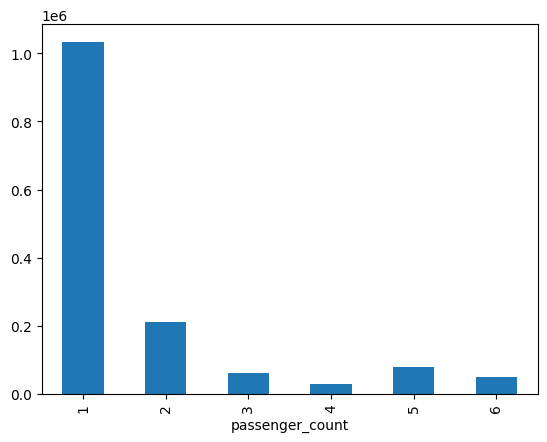

In [14]:
taxi_df['passenger_count'].value_counts().sort_index().plot(kind='bar')

<Axes: xlabel='passenger_count'>

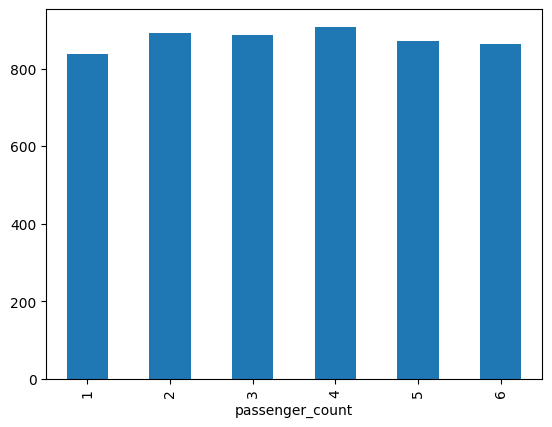

In [15]:
taxi_df.groupby('passenger_count')['trip_duration'].mean().plot(kind='bar')

- Passenger count = 0 has the highest average trip duration, which is not plausible, indicating likely data entry or logging errors

- Passenger count = 1 dominates at all hours
- Group trips (2–4 passengers) are more frequent in the evening and late night

##  pickup_longitude, pickup_latitude & dropoff_longitude, dropoff_latitude

In [16]:
print(taxi_df[gb.cols].describe())

       pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude
count      1.458644e+06     1.458644e+06       1.458644e+06      1.458644e+06
mean      -7.397341e+01     4.075093e+01      -7.397310e+01      4.075180e+01
std        3.815748e-02     2.808493e-02       3.433933e-02      3.211049e-02
min       -7.405000e+01     4.059000e+01      -7.405000e+01      4.059000e+01
25%       -7.399187e+01     4.073735e+01      -7.399133e+01      4.073588e+01
50%       -7.398174e+01     4.075410e+01      -7.397975e+01      4.075452e+01
75%       -7.396733e+01     4.076836e+01      -7.396301e+01      4.076981e+01
max       -7.373000e+01     4.090000e+01      -7.373000e+01      4.090000e+01


- Some trip coordinates lie outside NYC bounds
- Some points lie far outside the visible city bounds — likely due to GPS glitches or data corruption.

## Geographic distribution

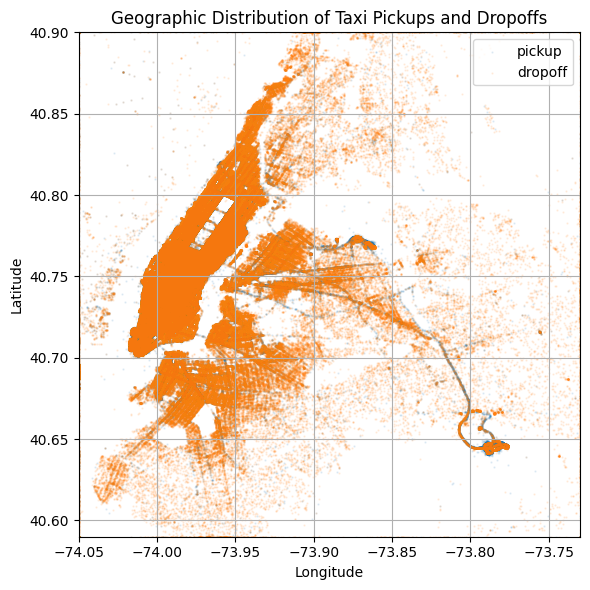

In [17]:
# Scatterplot of pickup and dropoff locations
plt.figure(figsize=(6, 6))
plt.scatter(taxi_df['pickup_longitude'], taxi_df['pickup_latitude'], s=0.5, alpha=0.1,
            label='pickup')
plt.scatter(taxi_df['dropoff_longitude'], taxi_df['dropoff_latitude'], s=0.5, alpha=0.1,
            label='dropoff')
plt.xlim(gb.min_lon, gb.max_lon)
plt.ylim(gb.min_lat, gb.max_lat)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(loc='upper right')
plt.title("Geographic Distribution of Taxi Pickups and Dropoffs")
plt.grid(True)
plt.tight_layout()
plt.show()

- Most pickups and dropoffs are located within the NYC area (Manhattan, Brooklyn, Queens).
- Clear density clusters appear around Midtown and Downtown Manhattan.

##  store_and_fwd_flag

In [18]:
print(taxi_df['store_and_fwd_flag'].value_counts(dropna=False))

store_and_fwd_flag
N    1450599
Y       8045
Name: count, dtype: int64


- store_and_fwd_flag = 'Y' is rare and likely not predictive on its own

##  trip_duration

In [19]:
taxi_df['trip_duration'].describe()

count     1458644
unique       5996
top            60
freq         8777
Name: trip_duration, dtype: int64

<Axes: ylabel='Frequency'>

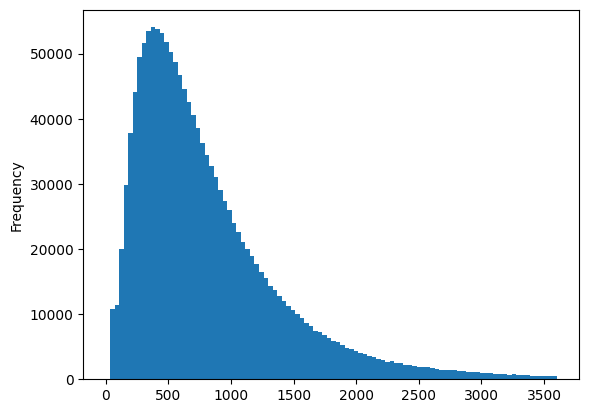

In [20]:
taxi_df['trip_duration'].plot.hist(bins=100, range=(0, 3600))  # bis 1 Stunde

- Several trips have a duration longer than 2 hours, which is highly unlikely for intra-city NYC taxi rides. A few trips are also shorter than 1 minute, which may indicate errors or missing data.

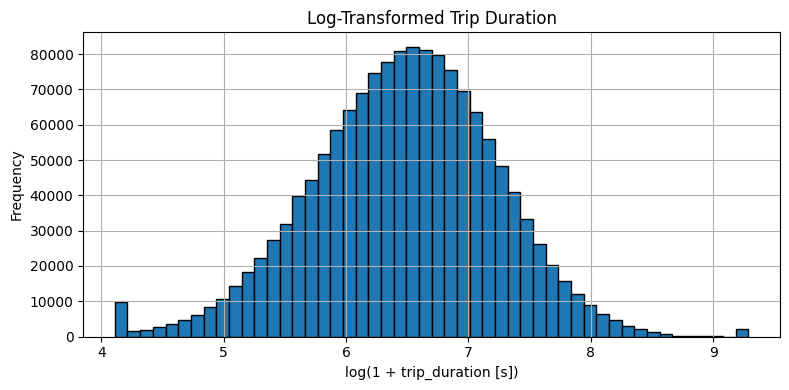

In [21]:
plt.figure(figsize=(8, 4))
plt.hist(taxi_df['trip_duration_log'], bins=50, edgecolor='black')
plt.title("Log-Transformed Trip Duration")
plt.xlabel("log(1 + trip_duration [s])")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

## distance feature (Haversine)

<Axes: xlabel='hav_dist_km', ylabel='trip_duration_log'>

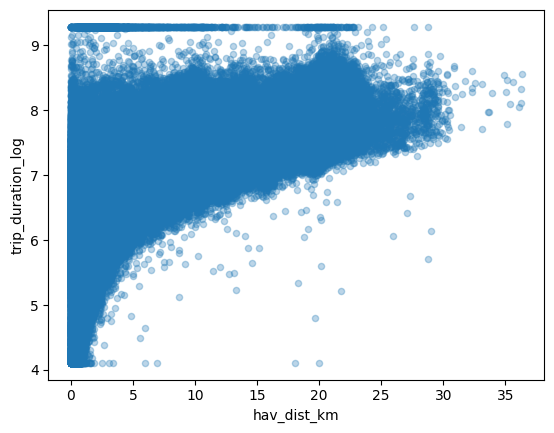

In [22]:
taxi_df.plot.scatter(x='hav_dist_km', y='trip_duration_log', alpha=0.3)

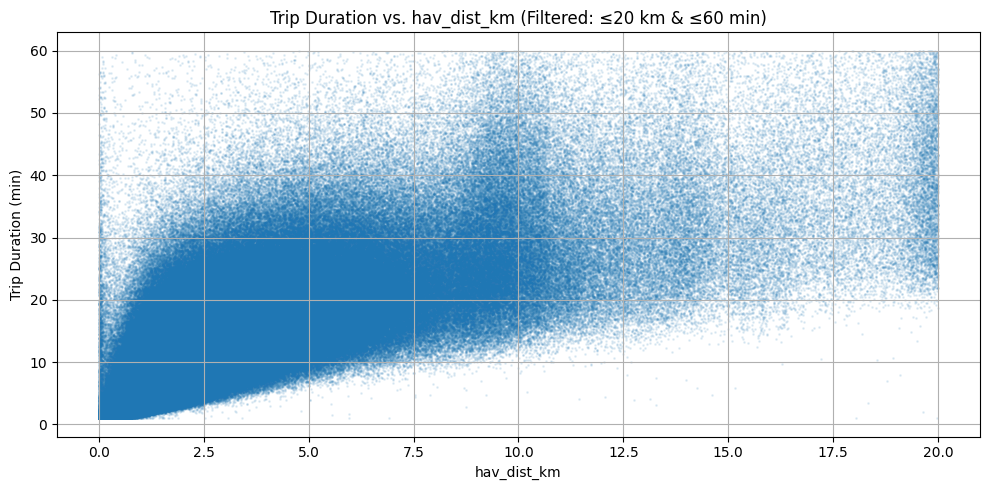

In [23]:
# Filter for clearer visualization
filtered_data = taxi_df[
  (taxi_df['route_distance_km'] <= 20) &
  (taxi_df['hav_dist_km'] > 0.0) &
  (taxi_df['trip_duration_min'] <= 60) &
  (taxi_df['trip_duration_min'] > 0)
  ]

# Plot
plt.figure(figsize=(10, 5))
plt.scatter(filtered_data['hav_dist_km'], filtered_data['trip_duration_min'], alpha=0.1, s=1)
plt.xlabel("hav_dist_km")
plt.ylabel("Trip Duration (min)")
plt.title("Trip Duration vs. hav_dist_km (Filtered: ≤20 km & ≤60 min)")
plt.grid(True)
plt.tight_layout()
plt.show()

- Long durations at very short distances
- Long distances with short durations